In [55]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
import sys
from matplotlib import pyplot as plt

In [56]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 2
ALT_MIN, ALT_MAX = 0.5, 64.5
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
CHORDAL_DIST = 2 * np.sin(MAX_DIST_KM / (2 * EARTH_RADIUS_KM))
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000
CHUNK_SIZE_S_PROCESS = 2000
BATCH_SIZE = 10000

In [57]:
def process_dataarray(da_o3):
    da_transposed = da_o3.transpose('time', 'altitude')
    
    n_time = da_transposed.sizes['time']
    n_alt = da_transposed.sizes['altitude']
    
    time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
    alt_chunks = min(32, n_alt)
    
    if isinstance(da_transposed.data, da.Array):
        da_transposed = da_transposed.chunk({'time': time_chunks, 'altitude': alt_chunks})
    else:
        da_transposed.data = da.from_array(da_transposed.data, 
                                          chunks=(time_chunks, alt_chunks))
    
    return da_transposed

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute and raw difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), np.abs(diff_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [58]:
sys.path.extend([
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\OSIRIS",
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\ACEFTS"
])

import OSIRIS_helper as OSIRIS
import ACEFTS_helper as ACE

In [59]:
daL = OSIRIS.get_vmr()
daS = ACE.get_vmr()

In [60]:
daL = daL.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})
daS = daS.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})

daL = process_dataarray(daL)
daS = process_dataarray(daS)

assert np.array_equal(daL.altitude.values, ALT_GRID), "OSIRIS alt mismatch!"
assert np.array_equal(daS.altitude.values, ALT_GRID), "ACE-FTS alt mismatch!"

In [61]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)


C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57339 instead
  warnings.warn(


In [62]:
o3L_arr = daL.values.astype(np.float32)
o3S_arr = daS.values.astype(np.float32)
tL = daL.time.values.astype('datetime64[ns]')
tS = daS.time.values.astype('datetime64[ns]')
latL = daL.latitude.values
lonL = daL.longitude.values
latS = daS.latitude.values
lonS = daS.longitude.values

tS_min = tS.min() - TIME_TOL
tS_max = tS.max() + TIME_TOL
time_mask = (tL >= tS_min) & (tL <= tS_max)
tL_filtered = tL[time_mask]
o3L_arr_filtered = o3L_arr[time_mask]
latL_filtered = latL[time_mask]
lonL_filtered = lonL[time_mask]

client.close()
cluster.close()
del o3L_arr, latL, lonL
gc.collect()

C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3363: UserWarning: Sending large graph of size 65.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


28286

In [72]:
tL_ns = tL_filtered.astype(np.int64)
tS_ns = tS.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)
n_alt = len(ALT_GRID)

MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
stats = {dtype: {'sum': np.zeros(n_alt), 'sum_sq': np.zeros(n_alt), 'count': np.zeros(n_alt)} 
         for dtype in ['rel', 'abs', 'raw']}

time_bins = np.arange(tL_ns.min(), tL_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tL_ns, time_bins)
time_binned = {bin_id: [] for bin_id in range(len(time_bins)+1)}
for idx, bin_id in enumerate(bin_indices):
    time_binned[bin_id].append(idx)

for s_idx in range(len(tS)):
    if s_idx % 10000 == 0:
        print(f"Processing ACE-FTS point {s_idx}/{len(tS)}...")
    
    s_time = tS_ns[s_idx]
    s_lat = latS[s_idx]
    s_lon = lonS[s_idx]
    
    min_time = s_time - TIME_TOL_ns
    max_time = s_time + TIME_TOL_ns
    min_bin = np.digitize(min_time, time_bins)
    max_bin = np.digitize(max_time, time_bins) + 1
    
    best_dist = float('inf')
    best_L_idx = None
    
    for bin_id in range(min_bin, max_bin):
        if bin_id not in time_binned or not time_binned[bin_id]:
            continue
            
        for L_idx in time_binned[bin_id]:
            if abs(tL_ns[L_idx] - s_time) > TIME_TOL_ns:
                continue
                
            L_lat = latL_filtered[L_idx]
            L_lon = lonL_filtered[L_idx]
            
            dist = haversine_vectorized(s_lat, s_lon, L_lat, L_lon)
            
            if dist <= MAX_DIST_KM and dist < best_dist:
                best_dist = dist
                best_L_idx = L_idx
    
    if best_L_idx is not None:
        o3L_val = o3L_arr_filtered[best_L_idx]
        o3S_val = o3S_arr[s_idx]
        
        rel_diff, abs_diff, raw_diff = compute_diffs(
            o3L_val, 
            o3S_val
        )
        
        for dtype, diff_array in zip(['rel', 'abs', 'raw'], 
                                    [rel_diff, abs_diff, raw_diff]):
            for alt_idx in range(n_alt):
                val = diff_array[alt_idx]
                if not np.isnan(val):
                    stats[dtype]['sum'][alt_idx] += val
                    stats[dtype]['sum_sq'][alt_idx] += val**2
                    stats[dtype]['count'][alt_idx] += 1
        
        processed_pairs += 1
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at ACE point {s_idx}...")

print(f"Total coincidences found: {processed_pairs}")

Processing ACE-FTS point 0/132071...
Processing ACE-FTS point 10000/132071...
Found 1000 pairs at ACE point 14359...
Processing ACE-FTS point 20000/132071...
Found 2000 pairs at ACE point 23709...
Processing ACE-FTS point 30000/132071...
Found 3000 pairs at ACE point 30832...
Processing ACE-FTS point 40000/132071...
Found 4000 pairs at ACE point 42460...
Processing ACE-FTS point 50000/132071...
Found 5000 pairs at ACE point 57074...
Processing ACE-FTS point 60000/132071...
Processing ACE-FTS point 70000/132071...
Processing ACE-FTS point 80000/132071...
Found 6000 pairs at ACE point 89659...
Processing ACE-FTS point 90000/132071...
Processing ACE-FTS point 100000/132071...
Processing ACE-FTS point 110000/132071...
Processing ACE-FTS point 120000/132071...
Processing ACE-FTS point 130000/132071...
Total coincidences found: 6675


C:\Users\salla\AppData\Local\Temp\ipykernel_2720\4220225895.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(np.arange(len(stats["rel"]["sum"] / stats["rel"]["count"])), (stats["rel"]["sum"] / stats["rel"]["count"]))


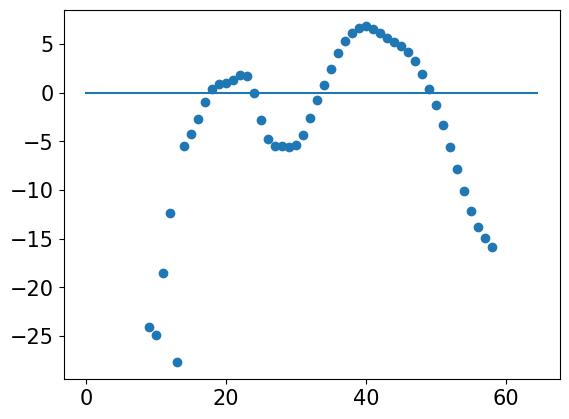

In [70]:
plt.scatter(np.arange(len(stats["rel"]["sum"] / stats["rel"]["count"])), (stats["rel"]["sum"] / stats["rel"]["count"]))
plt.plot([0,64.5],[0,0])